In [11]:
!pip install opencv-python

In [92]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [139]:
img = cv2.imread('./Datasets/test_images/sharapova1.jpg')
img.shape

(555, 700, 3)

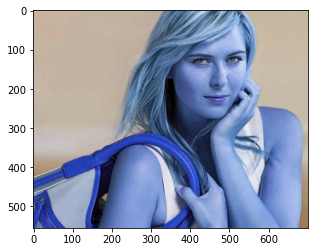

In [140]:
plt.imshow(img)

In [141]:
grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
grey.shape

(555, 700)

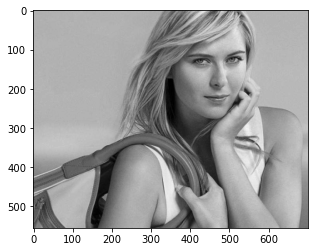

In [142]:
plt.imshow(grey, cmap='gray')

#### Calling Open CV Cascadeclassifier for detecting Faces & eyes

In [143]:
face_cascade = cv2.CascadeClassifier(r'C:\Users\jadha\Documents\class notes\CodeBasics\py-master\DataScience\CelebrityFaceRecognition\model\opencv\haarcascades\haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(r'C:\Users\jadha\Documents\class notes\CodeBasics\py-master\DataScience\CelebrityFaceRecognition\model\opencv\haarcascades\haarcascade_eye.xml')

In [144]:
faces = face_cascade.detectMultiScale(grey,1.3)
faces

array([[352,  38, 233, 233]], dtype=int32)

In [145]:
# for face in faces:
#     print (x,y,w,h =face)

In [146]:
x,y,w,h = faces[0]
x,y,w,h

(352, 38, 233, 233)

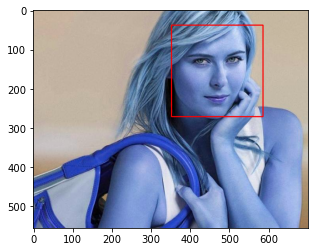

In [147]:
face_img = cv2.rectangle(img, (x,y), ((x+w),(y+h)), (255,0,0),2)
plt.imshow(face_img)

In [148]:
cv2.destroyAllWindows()
for x,y,w,h in faces:
    face_img = cv2.rectangle(img, (x,y), (x+w,y+h),(255,0,0),2)
    roi_gray = grey[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for ex,ey,ew,eh in eyes:
        cv2.rectangle(roi_color, (ex,ey), (ex+ew,ey+eh),(0,255,0),4)

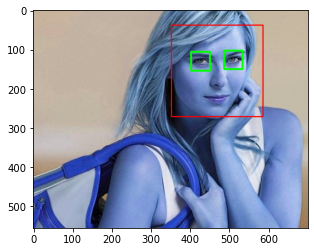

In [149]:
plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

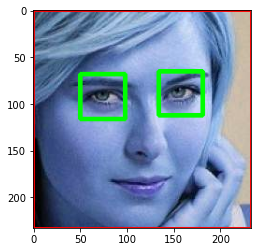

In [104]:
plt.imshow(roi_color, cmap='gray')

In [105]:
def get_cropped_image_with_2_eyes(image_path):
    img = cv2.imread(image_path)
    grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(grey,1.3)
    for face in faces:
        x,y,w,h = face
        roi_color = img[y:y+h, x:x+w]
        roi_grey = grey[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_grey,1.3)
        if len(eyes) >=2:
            return roi_color

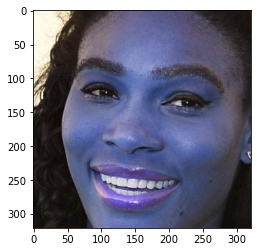

In [150]:
croped_image= get_cropped_image_with_2_eyes('./Datasets/test_images/serena_2.jpg')
plt.imshow(croped_image)

### using os & shutil to work on directories

In [54]:
path_to_data = './Datasets/train_images'
path_to_cr_data = './Datasets/train_images/Cropped_images'

In [55]:
import os

In [56]:
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [57]:
img_dirs

['./Datasets/train_images\\lionel_messi',
 './Datasets/train_images\\maria_sharapova',
 './Datasets/train_images\\roger_federer',
 './Datasets/train_images\\serena_williams',
 './Datasets/train_images\\virat_kohli']

In [58]:
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [119]:
celeb_file_name_dict = {}
for img_dir in img_dirs:
    count = 1
    celeb_name = img_dir.split('\\')[-1]
    print (celeb_name)
    celeb_file_name_dict[celeb_name]= []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_with_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data +'\\'+ celeb_name
            if not os.path.exists(cropped_folder):
                os.mkdir(cropped_folder)
                print ('Generating cropped Folder', celeb_name)
            cropped_file_name = celeb_name + '_' + str(count) + '.png'
            cropped_file_path = cropped_folder + '\\' + cropped_file_name
            
            cv2.imwrite(cropped_file_path, roi_color)
            count +=1
            celeb_file_name_dict[celeb_name].append(cropped_file_path)

lionel_messi
maria_sharapova
roger_federer
serena_williams
virat_kohli
Generating cropped Folder virat_kohli


## Wavelenght Transform

In [137]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

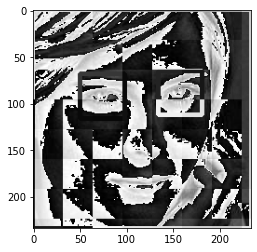

In [151]:
im_har = w2d(roi_color,'db1',5)
plt.imshow(im_har, cmap='gray')

In [213]:
celeb_dict = {}
for c, celeb in enumerate(celeb_file_name_dict.keys()):
    celeb_dict[celeb] = c
celeb_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

## Gettting X & y for model training

In [161]:
X = []
y = []
for celeb, train_data in celeb_file_name_dict.items():
    for train_image in train_data:
        img = cv2.imread(train_image)
        if img is None:
            continue
        scaled_img = cv2.resize(img, (32,32))
        img_har = w2d(img, 'db1', 5)
        scaled_img_har = cv2.resize(img_har, (32,32))
        combined_img = np.vstack((scaled_img.reshape(32*32*3,1),scaled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(celeb_dict[celeb])

In [163]:
len(X[0])

4096

In [165]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(129, 4096)

In [166]:
X[0]

array([100., 129., 140., ..., 237., 234., 232.])

## model training

In [262]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [241]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, random_state=1)

In [242]:
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf',C=1))])

In [243]:
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8461538461538461

In [244]:
print (classification_report(pipe.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       1.00      0.90      0.95        10
           2       0.50      1.00      0.67         1
           3       1.00      1.00      1.00         1
           4       0.83      0.91      0.87        11

    accuracy                           0.85        26
   macro avg       0.77      0.83      0.78        26
weighted avg       0.85      0.85      0.84        26



In [249]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [250]:
model_params= {
    'svm': {
        'model': SVC(),
        'params' : {'svc__C':[1,10,100,1000],
                   'svc__kernel': ['rbf', 'linear']
                   }
    },
    'random_forest': {
        'model' : RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model' : LogisticRegression(solver='liblinear'),
        'params' : {
            'logisticregression__C': [1,5,10]
        }
    }
    
}

In [256]:
scores = []
best_estimators = {}
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv=5)
    clf.fit(X_train, y_train)
    scores.append({
        'model' : algo,
        'best_score' : clf.best_score_,
        'best_params' : clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
df

,model,best_score,best_params
0,svm,0.728095,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.620952,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.758095,{'logisticregression__C': 1}


In [257]:
best_estimators['svm'].score(X_test, y_test)

0.9230769230769231

In [258]:
best_estimators['random_forest'].score(X_test, y_test)

0.7307692307692307

In [259]:
best_estimators['logistic_regression'].score(X_test, y_test)

0.9230769230769231

In [260]:
best_clf = best_estimators['svm']

In [261]:
import seaborn as sns

In [266]:
print (confusion_matrix(y_test, best_clf.predict(X_test)))

[[ 1  0  0  0  1]
 [ 0  9  0  0  0]
 [ 0  0  2  0  0]
 [ 0  0  0  1  0]
 [ 0  1  0  0 11]]


In [267]:
print (classification_report(y_test, best_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.90      1.00      0.95         9
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         1
           4       0.92      0.92      0.92        12

    accuracy                           0.92        26
   macro avg       0.96      0.88      0.91        26
weighted avg       0.93      0.92      0.92        26



Text(0.5, 1.0, 'Confusion Matrix')

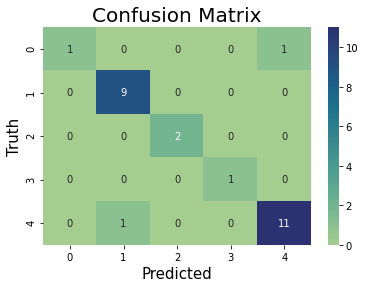

In [276]:
sns.heatmap(confusion_matrix(y_test, best_clf.predict(X_test)), annot=True, cmap='crest')
plt.xlabel('Predicted', size=15)
plt.ylabel('Truth', size = 15)
plt.title('Confusion Matrix', size=20)